<a href="https://colab.research.google.com/github/bghata/Sentiment_Analysis/blob/master/Sentiment_Analysis_iPhone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext rpy2.ipython

import warnings
warnings.filterwarnings('ignore')

In [0]:
%%R
install.packages("pacman")
library(pacman)

## Loading libraries

In [0]:
%%R
pacman::p_load(readr, data.table, dplyr,caret, 
               ggplot2, plotly, lubridate, kernlab,
               forecast, ggfortify, stats, tufte, 
               ggthemes, rapportools, fpp2, gbm, scatterplot3d,
               reshape2, Hmisc, rio, VIM, class, spdep, 
               randomForest, magrittr, Matrix, foreach, 
               iterators, doParallel, corrplot, C50, e1071, kknn)

## Loading data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
%%R
iphone_data <- read_csv('/content/gdrive/My Drive/Colab Notebooks/AWS/iphone_smallmatrix_labeled_8d.csv')

## Feature selection

**Correlation matrix**

**on iphone_data**

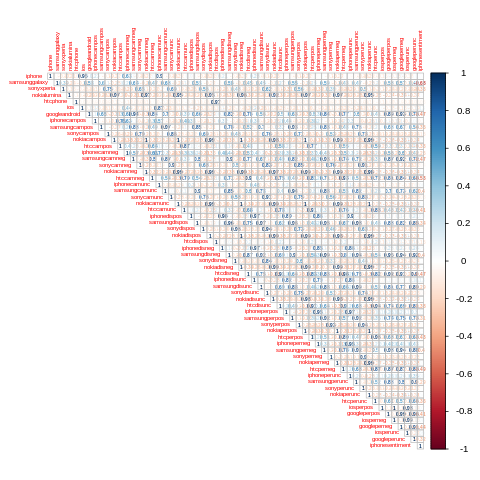

In [0]:
%%R
iphone_cor <- cor(iphone_data)
corrplot(cor(iphone_cor), method="number", type = "upper", 
tl.cex = 0.5, number.cex = 0.4)

## Examine feature variance

**The distribution of values within a feature is related to how much information that feature holds in the data set. Features with no variance can be said to hold little to no information. Features that have very little, or "near zero variance", may or may not have useful information.**

In [0]:
%%R
nzvMetrics_iphone <- nearZeroVar(iphone_data, saveMetrics = TRUE)

**nearZeroVar() with saveMetrics = FALSE returns an vector**

In [0]:
%%R
nzv_iphone <- nearZeroVar(iphone_data, saveMetrics = FALSE) 

**NZV - create a new data set and remove near zero variance features**

In [0]:
%%R
iphone_NZV <- iphone_data[,-nzv_iphone]
iphone_NZV$iphonesentiment <- as.factor(iphone_NZV$iphonesentiment)

## Recursive Feature Elimination (RFE)

**Sampling the data before using RFE**

**RFE is a form of automated feature selection. RFE with random forest will try every combination of feature subsets and return a final list of recommended features.**

**On iphone**

In [0]:
%%R
set.seed(123)
iphone_data$iphonesentiment <- as.factor(iphone_data$iphonesentiment)
iphoneSample <- iphone_data[sample(1:nrow(iphone_data), 1000, replace=FALSE),]

**Set up rfeControl with randomforest, repeated cross validation and no updates**

In [0]:
%%R
ctrl <- rfeControl(functions = rfFuncs, 
                   method = "repeatedcv",
                   repeats = 5,
                   verbose = FALSE)

**Use rfe and omit the response variable (attribute 59 iphonesentiment)**

In [0]:
%%R
rfeResults_iphone <- rfe(iphoneSample[,1:58], 
                  iphoneSample$iphonesentiment, 
                  sizes=(1:58), 
                  rfeControl=ctrl)
rfeResults_iphone

**Loading model rfeResults_iphone**

In [0]:
%%R
rfeResults_iphone <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/rfeResults_iphone.RDS")

**Plot results**

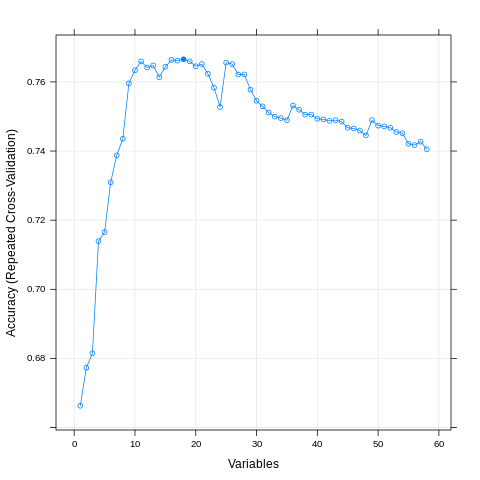

In [0]:
%%R
plot(rfeResults_iphone, type=c("g", "o"))

**Create new data set with rfe recommended features on iphone**

In [0]:
%%R
iphone_RFE <- iphone_data[, predictors(rfeResults_iphone)]

**Add dependent variable to iphone_RFE**

In [0]:
%%R
iphone_RFE$iphonesentiment <- iphone_data$iphonesentiment

# Testing 4 different models on iphone

## Data partition on iphone

In [0]:
%%R
trainData1 <- createDataPartition(iphone_data$iphonesentiment,
                                p=0.70,
                                list = FALSE)
trainSet1 <- iphone_data[trainData1, ]
testSet1 <- iphone_data[-trainData1, ]

## Random Forest model on iphone

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                     number = 10,
                     repeats = 1)

In [0]:
rf_iphone <- randomForest(iphonesentiment ~.,
                             data = trainSet1,
                             ntree = 100,
                             mtry = 2,
                             do.trace = TRUE,
                             trControl = fitControl,
                             imporve = 0.05,
                             nodesize = 5)

**Loading model rf_iphone**

In [0]:
%%R
rf_iphone <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/rf_iphone.RDS")

**Testing Random Forest model on testSet1**

In [0]:
%%R
RF_Pred_iphone <- predict(rf_iphone, newdata = testSet1)
RF_CM_iphone <- confusionMatrix(RF_Pred_iphone, testSet1$iphonesentiment)

In [0]:
%%R
postResample(RF_Pred_iphone, testSet1$iphonesentiment)

 Accuracy     Kappa 
0.6940874 0.3516046 


## KKNN model on iphone

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                     number = 10,
                     repeats = 1)

In [0]:
%%R
kknn_iphone <- train(iphonesentiment ~.,
                               data = trainSet1,
                               method = 'kknn',
                               tuneLength = 5,
                               trControl = fitControl)

**Loading model kknn_iphone**

In [0]:
%%R
kknn_iphone <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/kknn_iphone.RDS")

**Testing KKNN model on testSet1**

In [0]:
%%R
kknn_Pred_iphone <- predict(kknn_iphone, newdata = testSet1)
kknn_CM_iphone <- confusionMatrix(kknn_Pred_iphone, testSet1$iphonesentiment)

In [0]:
%%R
postResample(kknn_Pred_iphone, testSet1$iphonesentiment)

 Accuracy     Kappa 
0.3637532 0.1947588 


## Gradient Boosting Trees model on iphone

In [0]:
%%R
myGrid <- expand.grid(n.trees = c(250), 
                      interaction.depth = 1, 
                      shrinkage = c(0.1),
                      n.minobsinnode = 20

In [0]:
GB_iphone <- train((iphonesentiment ~ .), 
                      data = trainSet1, 
                      method = "gbm",
                      trControl = fitControl,
                      tuneGrid = myGrid)

**Loading model GB_iphone**

In [0]:
%%R
GB_iphone <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/GB_iphone.RDS")

**Testing Gradient Boosting Trees model on testSet1**

In [0]:
%%R
GB_Pred_iphone <- predict(GB_iphone, newdata = testSet1)
GB_CM_iphone <- confusionMatrix(GB_Pred_iphone, testSet1$iphonesentiment)

In [0]:
%%R
postResample(GB_Pred_iphone, testSet1$iphonesentiment)

 Accuracy     Kappa 
0.7516710 0.5093831 


## SVM model on iphone

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 3,
                           verboseIter = T)

In [0]:
%%R
svm_iphone <- train(iphonesentiment ~., data = trainSet1,
              method = "svmLinear",
              trControl= fitControl,
              preProcess = c("center", "scale"))

**Loading model svm_iphone**

In [0]:
%%R
svm_iphone <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/svm_iphone.RDS")

**Testing SVM model on testSet1**

In [0]:
%%R
SVM_Pred_iphone <- predict(svm_iphone, newdata = testSet1)
SVM_CM_iphone <- confusionMatrix(SVM_Pred_iphone, testSet1$iphonesentiment)

In [0]:
%%R
postResample(SVM_Pred_iphone, testSet1$iphonesentiment)

 Accuracy     Kappa 
0.6987147 0.3870698 


# Testing all 4  models on iphone_NZV

## Data partition on iphone_NZV

In [0]:
%%R
trainData2 <- createDataPartition(iphone_NZV$iphonesentiment,
                                  p=0.70,
                                  list = FALSE)
trainSet2 <- iphone_NZV[trainData2, ]
testSet2 <- iphone_NZV[-trainData2, ]

## Random Forest model on iphone_NZV

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 1)

In [0]:
%%R
rf_iphone_NZV <- randomForest(iphonesentiment ~.,
                          data = trainSet2,
                          ntree = 100,
                          mtry = 2,
                          do.trace = TRUE,
                          trControl = fitControl,
                          imporve = 0.05,
                          nodesize = 5)

**Loaading model rf_iphone_NZV**

In [0]:
%%R
rf_iphone_NZV <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/rf_iphone_NZV.RDS")

**Testing Random Forest model on testSet2**

In [0]:
%%R
RF_Pred_iphone_NZV <- predict(rf_iphone_NZV, newdata = testSet2)
RF_CM_iphone_NZV <- confusionMatrix(RF_Pred_iphone_NZV, testSet2$iphonesentiment)

In [0]:
%%R
postResample(RF_Pred_iphone_NZV, testSet2$iphonesentiment)

 Accuracy     Kappa 
0.7645244 0.5349137 


## Gradient Boosting Trees model on iphone_NZV 

In [0]:
%%R
myGrid <- expand.grid(n.trees = c(250), 
                      interaction.depth = 1, 
                      shrinkage = c(0.1),
                      n.minobsinnode = 20)

In [0]:
%%R
GB_iphone_NZV <- train((iphonesentiment ~ .), 
                   data = trainSet2, 
                   method = "gbm",
                   trControl = fitControl,
                   tuneGrid = myGrid)

In [0]:
%%R
GB_iphone_NZV <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/GB_iphone_NZV.RDS")

**Testing Gradient Boosting Trees model on testSet2**

In [0]:
%%R
GB_Pred_iphone_NZV <- predict(GB_iphone_NZV, newdata = testSet2)
GB_CM_iphone_NZV <- confusionMatrix(GB_Pred_iphone_NZV, testSet2$iphonesentiment)

In [0]:
%%R
postResample(GB_Pred_iphone_NZV, testSet2$iphonesentiment)

 Accuracy     Kappa 
0.7334190 0.4660807 


## SVM model on iphone_NZV

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 3,
                           verboseIter = T)

In [0]:
%%R
svm_iphone_NZV <- train(iphonesentiment ~., data = trainSet2,
                        method = "svmLinear",
                        trControl= fitControl,
                        preProcess = c("center", "scale"))

**Loading model svm_iphone_NZV**

In [0]:
%%R
svm_iphone_NZV <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/svm_iphone_NZV.RDS")

**Testing SVM model on testSet2**

In [0]:
%%R
SVM_Pred_iphone_NZV <- predict(svm_iphone_NZV, newdata = testSet2)
SVM_CM_iphone_NZV <- confusionMatrix(SVM_Pred_iphone_NZV, testSet2$iphonesentiment)

In [0]:
%%R
postResample(SVM_Pred_iphone_NZV, testSet2$iphonesentiment)

 Accuracy     Kappa 
0.6789203 0.3370553 


## KKNN model on iphone_NZV

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                     number = 10,
                     repeats = 1)

In [0]:
%%R
kknn_iphone_NZV <- train(iphonesentiment ~.,
                               data = trainSet2,
                               method = 'kknn',
                               tuneLength = 5,
                               trControl = fitControl)

**Loading model kknn_iphone_NZV**

In [0]:
%%R
kknn_iphone_NZV <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/kknn_iphone_NZV.RDS")

**Testing KKNN model on testSet2**

In [0]:
%%R
kknn_Pred_iphone_NZV <- predict(kknn_iphone_NZV, newdata = testSet2)
kknn_CM_iphone_NZV <- confusionMatrix(kknn_Pred_iphone_NZV, testSet2$iphonesentiment)

In [0]:
%%R
postResample(kknn_Pred_iphone_NZV, testSet2$iphonesentiment)

 Accuracy     Kappa 
0.3133676 0.1361982 


# Testing all 4 models on iphone_RFE

## Data partition on iphone_RFE

In [0]:
%%R
trainData3 <- createDataPartition(iphone_RFE$iphonesentiment,
                                  p=0.70,
                                  list = FALSE)
trainSet3 <- iphone_RFE[trainData3, ]
testSet3 <- iphone_RFE[-trainData3, ]

## Random Forest model on iphone_RFE

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 1)

In [0]:
%%R
rf_iphone_RFE <- randomForest(iphonesentiment ~.,
                              data = trainSet3,
                              ntree = 100,
                              mtry = 2,
                              do.trace = TRUE,
                              trControl = fitControl,
                              imporve = 0.05,
                              nodesize = 5)

**Loading model rf_iphone_RFE**

In [0]:
%%R
rf_iphone_RFE <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/rf_iphone_RFE.RDS")

**Testing Random Forest model on testSet3**

In [0]:
%%R
RF_Pred_iphone_RFE <- predict(rf_iphone_RFE, newdata = testSet3)
RF_CM_iphone_RFE <- confusionMatrix(RF_Pred_iphone_RFE, testSet3$iphonesentiment)

In [0]:
%%R
postResample(RF_Pred_iphone_RFE, testSet2$iphonesentiment)

    Accuracy        Kappa 
0.5007712082 0.0004136285 


## Gradient Boosting Trees model on iphone_RFE

In [0]:
%%R
myGrid <- expand.grid(n.trees = c(250), 
                      interaction.depth = 1, 
                      shrinkage = c(0.1),
                      n.minobsinnode = 20)

In [0]:
%%R
GB_iphone_RFE <- train((iphonesentiment ~ .), 
                       data = trainSet3, 
                       method = "gbm",
                       trControl = fitControl,
                       tuneGrid = myGrid)

**Loading model GB_iphone_RFE**

In [0]:
%%R
GB_iphone_RFE <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/GB_iphone_RFE.RDS")

**Testing Gradient Boosting Trees model on testSet3**

In [0]:
%%R
GB_Pred_iphone_RFE <- predict(GB_iphone_RFE, newdata = testSet3)
GB_CM_iphone_RFE <- confusionMatrix(GB_Pred_iphone_RFE, testSet3$iphonesentiment)

In [0]:
%%R
postResample(GB_Pred_iphone_RFE, testSet3$iphonesentiment)

 Accuracy     Kappa 
0.7493573 0.5071155 


## SVM model on iphone_RFE

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 3,
                           verboseIter = T)

In [0]:
svm_iphone_RFE <- train(iphonesentiment ~., data = trainSet3,
                        method = "svmLinear",
                        trControl= fitControl,
                        preProcess = c("center", "scale"))

**Loading model svm_iphone_RFE**

In [0]:
%%R
svm_iphone_RFE <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/svm_iphone_RFE.RDS")

**Testing SVM model on testSet3**

In [0]:
%%R
SVM_Pred_iphone_RFE <- predict(svm_iphone_RFE, newdata = testSet3)
SVM_CM_iphone_RFE <- confusionMatrix(SVM_Pred_iphone_RFE, testSet3$iphonesentiment)

In [0]:
%%R
postResample(SVM_Pred_iphone_NZV, testSet3$iphonesentiment)

   Accuracy       Kappa 
0.516452442 0.001602029 


## KKNN model on iphone_RFE

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 1)

In [0]:
%%R
kknn_iphone_RFE <- train(iphonesentiment ~.,
                         data = trainSet3,
                         method = 'kknn',
                         tuneLength = 5,
                         trControl = fitControl)

**Loading model kknn_iphone**

In [0]:
%%R
kknn_iphone_RFE <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/kknn_iphone_RFE.RDS")

**Testing KKNN model on testSet3**

In [0]:
%%R
kknn_Pred_iphone_RFE <- predict(kknn_iphone_RFE, newdata = testSet3)
kknn_CM_iphone_RFE <- confusionMatrix(kknn_Pred_iphone_RFE, testSet3$iphonesentiment)

In [0]:
%%R
postResample(kknn_Pred_iphone_RFE, testSet3$iphonesentiment)

 Accuracy     Kappa 
0.3583548 0.1883747 


# Importing iphoneLargeMatrix.csv

In [0]:
%%R
iphone_data_large <- read_csv('/content/gdrive/My Drive/Colab Notebooks/AWS/iphoneLargeMatrix.csv')

**Changing data type of iphonesentiment to be factor**

In [0]:
%%R
iphone_data_large$iphonesentiment <- as.factor(iphone_data_large$iphonesentiment)

# Since rf_iphone_NZV has the highest accuracy of 0.7645, therefore, the prediction was based on it

## Prediction with rf_iphone_NZV model on iphone_data_large

In [0]:
%%R
prediction = predict(rf_iphone_NZV, iphone_data_large)
iphone_data_large["iphonesentiment"] <- prediction
summary(prediction)

    0     1     2     3     4     5 
10466     0     0   118    26  7146 


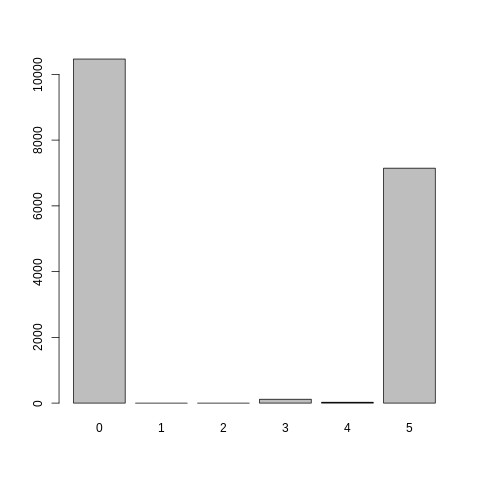

In [0]:
%%R
plot(prediction)